In [1]:
from sklearn import tree
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/train.csv')
X = df.drop(['PassengerId','Survived','Name','Ticket','Cabin'], axis = 1)
y = df['Survived']

In [6]:
median = X['Age'].median()
X = X .fillna({'Age':median})
# Сделаем это с помощью one-hot encoding. Можно было бы создать обьект энкодера чтобы сделать это
# Но проще это сделать с помощщью pd.get_dummies(dataframe) который сам распознает и все сделает
X = pd.get_dummies(X)

In [7]:
# Обучаем наше дерево решений
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [8]:
clf.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [9]:
# Для этого разделим нашу обучающую выборку на 2 части с помощью метода
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=42)

In [10]:
# Попробуем поискать оптимальную глубину дерева
# Создадим датафрейм куда будем добавлять результаты для дальнейшей визуализации
scores_data = pd.DataFrame()

In [15]:
# Цикл в котром будем обучать нашу модель с различным значением глубины
max_depth_values = range(1,100)
for value_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=value_depth)
    clf.fit(X_train,y_train)
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_test,y_test)
    # Создадим временный датафрейм куда будем добавлять результаты
    temp_score_data = pd.DataFrame({'max_depth':[value_depth],'train_score':[train_score],
                                    'test_score':[test_score]})
    
    # Добавляем временный датафрейм к главному. Нужно присваивать результат, аппенд работает не так как в списках
    scores_data = scores_data.append(temp_score_data)

In [22]:
scores_data.head()

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.840604,0.806780


Можно преобразовать получившийся датафрейм

In [17]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score','test_score'],
                          var_name='set_type',value_name='score')

In [19]:
scores_data_long

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604
...,...,...,...
193,95,test_score,0.772881
194,96,test_score,0.772881
195,97,test_score,0.772881
196,98,test_score,0.772881


In [ ]:
# Мы увеличили датафрейм в два раза, у каждой глубины теперь есть 2 записи для train и для test

Теперь визуализируем полученный результат. Сделайть это можно разными способами

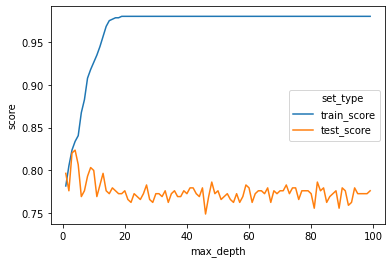

In [20]:
# Визуализируем длинный датасет
# hue параметр отвечающий за группировку
sns.lineplot(x='max_depth',y ='score',hue='set_type',data=scores_data_long);

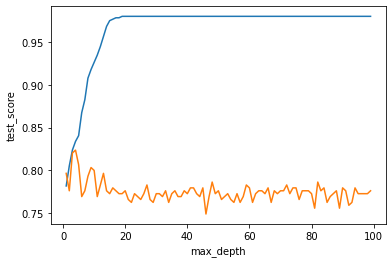

In [26]:
# Простой вариант на обычном датафрейме
sns.lineplot(x='max_depth',y='train_score',data=scores_data)
sns.lineplot(x='max_depth',y='test_score',data=scores_data);

 Мы подогнали нашу модель по конкретное тестовое множество, чтобы избежать этого нужно использовать 
 кросс-валидацию. Это когда тестовую выборку показывают модели только в финале. А до этого тренировочную выборку делят на несколько частей.При обучении одна часть выступает в роли тестовой а другие в роли тренировочной, и так столько раз насколько частей была разбита тренировочная выборка

In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [32]:
# Пробуем кросс валидацию на 5 частей
cross_val_score(clf,X_train,y_train,cv=5)

array([0.76666667, 0.82352941, 0.78991597, 0.75630252, 0.80672269])

In [37]:
cross_val_score(clf,X_train,y_train,cv=5).mean()

0.7685014005602241

In [39]:
scores_data = pd.DataFrame()

In [40]:
# Изменим процесс поиска глубины дерева
# Цикл в котром будем обучать нашу модель с различным значением глубины
max_depth_values = range(1,100)
for value_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=value_depth)
    clf.fit(X_train,y_train)
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_test,y_test)
    
    mean_cross_val_score = cross_val_score(clf,X_train,y_train,cv=5).mean()
    
    
    # Создадим временный датафрейм куда будем добавлять результаты
    temp_score_data = pd.DataFrame({'max_depth':[value_depth],
                                    'train_score':[train_score],
                                    'test_score':[test_score],
                                   'mean_cross_val_score':[mean_cross_val_score]})
    
    # Добавляем временный датафрейм к главному. Нужно присваивать результат, аппенд работает не так как в списках
    scores_data = scores_data.append(temp_score_data)

In [41]:
scores_data.head()

,max_depth,train_score,test_score,mean_cross_val_score
0,1,0.781879,0.796610,0.781961
0,2,0.805369,0.776271,0.770196
0,3,0.823826,0.820339,0.790322
0,4,0.833893,0.823729,0.788627
0,5,0.840604,0.810169,0.800392


In [43]:
# Изменим датафрейм для облегчения группировки
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'],
                           value_vars = ['train_score','test_score','mean_cross_val_score'],
                          var_name='set_type',value_name='score')

In [44]:
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


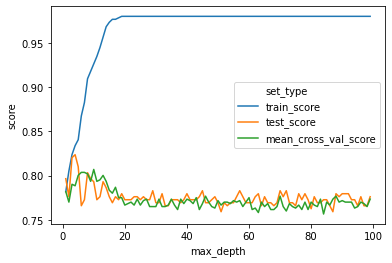

In [45]:
# Нарисуем график
sns.lineplot(x='max_depth',y='score',hue='set_type',data=scores_data_long);

In [49]:
# Лучшая глубина дерева исходя из графика это 10. Создадим классификатор с такими параметрами
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=10)

In [50]:
# Испытаем его на тестовых данных. Такой показатель уже лучше отражает способность нашей модели
# работать на новых данных
clf.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [51]:
clf.score(X_test,y_test)

0.8

# 2.4.12

In [62]:
df = pd.read_csv('../data/train_iris.csv')
df1 = pd.read_csv('../data/test_iris.csv')

In [69]:
np.random.seed(0)


In [58]:
df.head(1)

,Unnamed: 0,sepal length,sepal width,petal length,petal width,species
0,130,7.4,2.8,6.1,1.9,2


In [64]:
df1.head()

,Unnamed: 0,sepal length,sepal width,petal length,petal width,species
0,114,5.8,2.8,5.1,2.4,2
1,70,5.9,3.2,4.8,1.8,1
2,138,6.0,3.0,4.8,1.8,2
3,59,5.2,2.7,3.9,1.4,1
4,44,5.1,3.8,1.9,0.4,0


In [78]:
# Разделим датасет на тренировочный датасет и целевой признак
X_train = df.drop(['species','Unnamed: 0'],axis=1)
y_train = df['species']

X_test = df1.drop(['species','Unnamed: 0'],axis=1)
y_test = df1['species']

In [80]:
# Создадим датафрейм куда будем складывать значения результатов на тренировочной и тестовой выборке
scores_data = pd.DataFrame()

In [81]:
# Глубина дерева
depth_values = range(1,100)

for value in depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=value)
    clf.fit(X_train,y_train)
    train_score = clf.score(X_train,y_train)
    test_score = clf.score(X_test,y_test)
    temp_data = pd.DataFrame({'max_depth':[value],
                             'train_score':[train_score],
                             'test_score':[test_score]})
    scores_data = scores_data.append(temp_data)
    


In [82]:
scores_data

,max_depth,train_score,test_score
0,1,0.70,0.60
0,2,0.97,0.94
0,3,0.99,0.94
0,4,1.00,0.94
0,5,1.00,0.92
...,...,...,...
0,95,1.00,0.92
0,96,1.00,0.92
0,97,1.00,0.92
0,98,1.00,0.92


In [84]:
# Изменим датасет для лучшей визуализации
scores_data_long = pd.melt(scores_data,id_vars='max_depth',
                          value_vars=['train_score','test_score'],
                          var_name ='set_type', value_name = 'score')

In [85]:
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.70
1,2,train_score,0.97
2,3,train_score,0.99
3,4,train_score,1.00
4,5,train_score,1.00


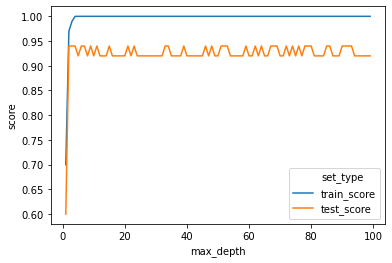

In [86]:
# Визуализируем
sns.lineplot(x='max_depth',y='score',hue='set_type',data=scores_data_long);

### 2.4.15

In [128]:
df = pd.read_csv('../data/dogs_n_cats.csv')

In [129]:
df.head(1)

,Длина,Высота,Шерстист,Гавкает,Лазает по деревьям,Вид
0,15,18.0,1,1,0,собачка


In [132]:
# Выделим тренировочный датасет и целевой признак
X_train = df.drop('Вид',axis=1)
y_train = df['Вид']

In [133]:
X_train.head()

,Длина,Высота,Шерстист,Гавкает,Лазает по деревьям
0,15,18.0,1,1,0
1,20,24.0,1,0,0
2,34,40.8,1,1,0
3,26,31.2,1,1,0
4,16,19.2,1,1,0


In [134]:
y_train

0      собачка
1      собачка
2      собачка
3      собачка
4      собачка
        ...   
995      котик
996      котик
997      котик
998      котик
999      котик
Name: Вид, Length: 1000, dtype: object

In [115]:
scores=pd.DataFrame()

In [122]:
# Обучаем дерево в итоге это не нужно можно обойтись просто деревом с глубиной 1
# for value in range(1,100):
#     clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=value)
#     clf.fit(X_train,y_train)
#     train_score = clf.score(X_train,y_train)
#     temp = pd.DataFrame({'max_depth':[value],'score':[train_score]})
#     scores = scores.append(temp)

In [136]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [137]:
test_df = pd.read_json('../data/dataset_209691_15.txt')

In [139]:
test_df.head(1)


,Длина,Высота,Шерстист,Гавкает,Лазает по деревьям
0,28,33.6,1,1,0


In [142]:
predicted = clf.predict(test_df)

In [145]:
predicted = pd.Series(predicted)

In [146]:
predicted.value_counts()

собачка    51
котик      49
dtype: int64